### Load modules

In [7]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

from zipfile import ZipFile
import cv2
from skimage.feature import hog
import os

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
with open('models.p', 'rb') as pfile:
    models = pickle.load(pfile)
    
linear_svc_rfc = models['linear_svc_rfc']
scaler = models['scaler']
model_rfc = models['model_rfc']

In [3]:
with open('data.p', 'rb') as f:
    data = pickle.load(f)
x_train, y_train = data['x_train'], data['y_train']

In [5]:
x_train = scaler.transform(x_train)
x_train = model_rfc.transform(x_train)
y_pred = linear_svc_rfc.predict(x_train)
acc = accuracy_score(y_train, y_pred)

In [91]:
def spatial_bin(img, dsize=(32, 32)):
    img_resized = cv2.resize(img, dsize)
    spatial_feature = img_resized.ravel()
    return spatial_feature

def color_hist(img, n_bins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[...,0], bins=n_bins, range=bins_range)
    channel2_hist = np.histogram(img[...,1], bins=n_bins, range=bins_range)
    channel3_hist = np.histogram(img[...,2], bins=n_bins, range=bins_range)
    
    hist_feature = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_feature

def calculate_hog(img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
    hog_feature = []
    for n in range(img.shape[2]):
        hog_feature_tmp = hog(img[...,n], orientations=orientations, pixels_per_cell=pixels_per_cell, 
                              cells_per_block=cells_per_block, block_norm='L2-Hys', 
                              visualise=False, transform_sqrt=True, feature_vector=True)
        hog_feature.append(hog_feature_tmp)
    hog_feature = np.array(hog_feature).ravel()
    return hog_feature

def extract_features(image_list, color_space='RGB', spatial_size=(32, 32),
                    n_color_hist_bins=32, color_hist_range=(0, 256)):
    features = []
    for img in image_list:
        if color_space != 'RGB':
            if color_space == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(img)
        img = cv2.resize(img, (64, 64))
        spatial_feature = spatial_bin(img, dsize=spatial_size)
        color_hist_feature = color_hist(img, n_bins=n_color_hist_bins, 
                                        bins_range=color_hist_range)
        hog_feature = calculate_hog(img)
        features.append(np.concatenate((spatial_feature, color_hist_feature, hog_feature)))
    
    features = np.array(features)
    return features

(720, 1280, 3)

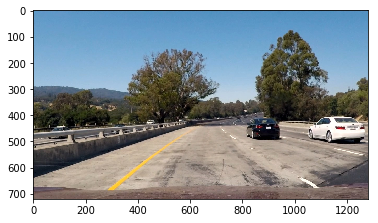

In [92]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

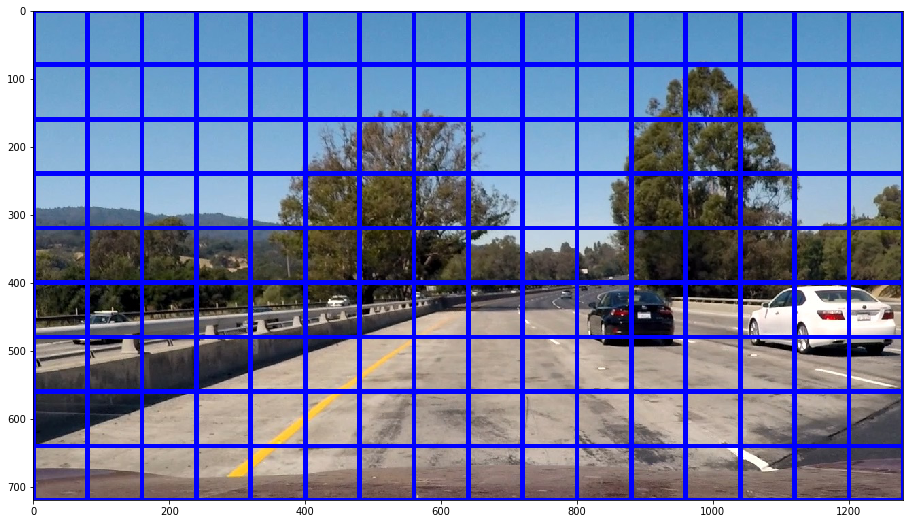

In [140]:
def draw_box(img, bboxes, color=(0, 0, 255), thick=6):
    img_copy = img.copy()
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], color, thick)
    return img_copy

def slide_window(img, img_list=None, x_start_stop=[None, None], y_start_stop=[None, None],
                window_height=64, window_width=64, overlap_width=0.5, overlap_height=0.5):
    if x_start_stop[0]==None:
        x_start_stop[0] = 0
    if y_start_stop[0]==None:
        y_start_stop[0] = 0
    if x_start_stop[1]==None:
        x_start_stop[1] = img.shape[1] 
    if y_start_stop[1]==None:
        y_start_stop[1] = img.shape[0] 
    
    x_grids = np.arange(x_start_stop[0], x_start_stop[1], int(window_width*(1-overlap_width)))
    y_grids = np.arange(y_start_stop[0], y_start_stop[1], int(window_height*(1-overlap_height)))
    
    bboxes = []
    if img_list==None:
        img_list = []
    for y_tmp in y_grids:
        for x_tmp in x_grids:
            bboxes.append([(x_tmp, y_tmp), (x_tmp+window_width, y_tmp+window_height)])
            img_list.append(img[y_tmp:y_tmp+window_height, x_tmp:x_tmp+window_width, :])
                
            
    return bboxes, img_list

bboxes, bboxes_img = slide_window(img, x_start_stop=[0, None], y_start_stop=[0, None],
                                  window_height=80, window_width=80, overlap_height=0, overlap_width=0)
img_box = draw_box(img, bboxes)
plt.figure(figsize=(16, 9))
plt.imshow(img_box)

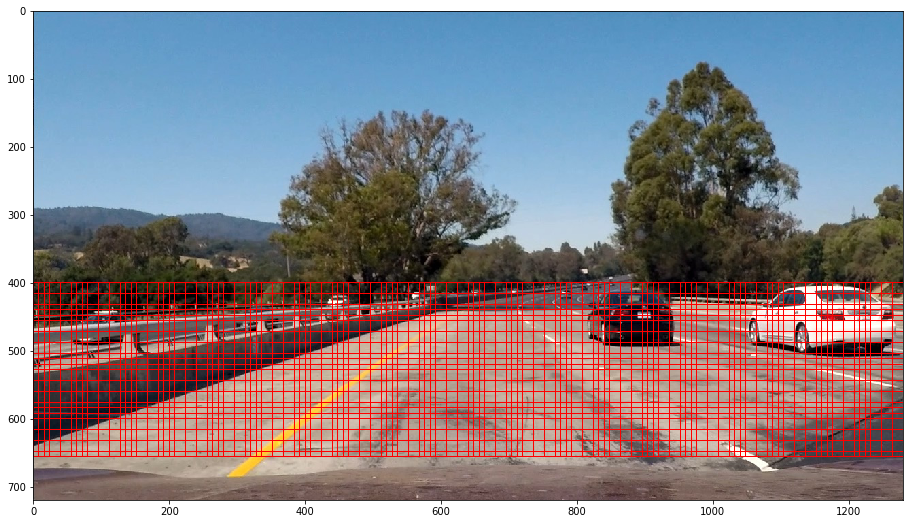

In [163]:
img_copy = img.copy()
bboxes = []
for x in range(0, 1280, 8):
    for y in range(400, 656, 8):
        bboxes.append([(x, y), (x+8, y+8)])
        img_copy = cv2.rectangle(img_copy, (x, y), (x+8, y+8), (255, 0, 0), 1)
# img_copy = cv2.rectangle(img_copy, (0, 400), (1280, 656), (0, 0, 255), 5)
# img_copy = draw_box(img_copy, bboxes, (255, 0, 0), 1)
plt.figure(figsize=(16, 9))
plt.imshow(img_copy)

In [128]:
window_sizes = np.arange(32, 60, 32)
img_list = []
for w in window_sizes:
    boxes, img_list = slide_window(img, img_list, x_start_stop=[10, None], y_start_stop=[300, None],
                                  window_height=w, window_width=w, overlap_height=0.6, overlap_width=0.6)

# len(img_list)
features = extract_features(img_list, color_space='HSV')
features.shape

(3432, 11916)

In [129]:
features = scaler.transform(features)
features = model_rfc.transform(features)
pred = linear_svc_rfc.predict(features)

In [130]:
img_copy = draw_box(img, [boxes[n] for n in range(len(boxes)) if pred[n]==1])

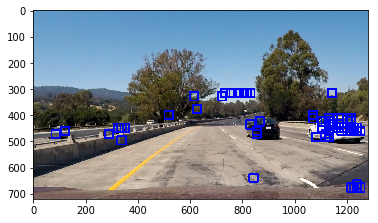

In [131]:
plt.imshow(img_copy)

In [153]:
256/8

32.0